## Import Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

%matplotlib inline

from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import KFold

### 모델 학습 graph 

In [2]:
def plot_curve(epochs, hist, list_of_metrics):
    
    fig, ax = plt.subplots(1,2,figsize = (12, 8))
    
    for i in range(len(ax)):
        ax[i].set_xlabel('Epochs')
        ax[i].set_ylabel('Value')
        
        for n in range(len(list_of_metrics)):
            if i == 0:
                y = hist[list_of_metrics[n]]
                if n == 0:
                    ax[i].plot(epochs, y, label="train")
                else:
                    ax[i].plot(epochs, y, label="val")
                ax[i].set_title('Loss')
                ax[i].legend(loc='upper right')
                if n == 1:
                    break
            else:
                if n >= 2:
                    y = hist[list_of_metrics[n]]
                    if n == 2:
                        ax[i].plot(epochs, y, label="train")
                    else:
                        ax[i].plot(epochs, y, label="val")
                    ax[i].set_title('Accuracy')
                    ax[i].legend(loc='lower right')
                    
    plt.show()

모델이 학습한 후의 그래프를 보여줍니다.  
정확도와 오차를 보기 쉽게 비교해줍니다.

### alphabet image

In [3]:
def digit_image(x):
    return np.where(x>=150, x, 0)

원본 이미지에서 숫자만 따로 추출하는 함수입니다.  
숫자 전부가 아닌 알파벳 마스크 때문에 가려진 부분은 추출되지 않을 것 입니다.

## Train

In [4]:
with open('./pickle/data.npy', 'rb') as f:
    X_trains= np.load(f)
    y_trains = np.load(f)
    TEST = np.load(f)

In [5]:
print(X_trains.shape)
print(y_trains.shape)
print(TEST.shape)

(2048, 28, 28, 3)
(2048, 10)
(20480, 28, 28, 3)


In [6]:
# X_trains = X_trains.astype('float32') / 255.
# TEST = TEST.astype('float32') / 255.

In [7]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import SeparableConv2D, Input, Conv2D, Add, BatchNormalization, concatenate, AveragePooling2D, add, MaxPooling2D 
from tensorflow.keras.layers import Conv2DTranspose, Activation, Dropout,UpSampling2D, GlobalAveragePooling2D, Dense ,ZeroPadding2D, LeakyReLU
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.losses import sparse_categorical_crossentropy

### DenseNet

In [8]:
def Conv_block(x, filter_unit, activation='relu'):
    
    # 28x28x128
    x_l = Conv2D(filter_unit, (1,1), padding='same', kernel_initializer='he_normal')(x)
    x_l = BatchNormalization()(x_l)
    x_l = Activation(activation)(x_l)
    
    x_l = Conv2D(filter_unit, (3,3), strides=(2,2), padding='same', kernel_initializer='he_normal')(x_l)
    x_l = BatchNormalization()(x_l)
    x_l = Activation(activation)(x_l)
    
    x_l = Conv2D(filter_unit*4, (1,1), padding='same', kernel_initializer='he_normal')(x_l)
    x_l = BatchNormalization()(x_l)
    
    short = Conv2D(filter_unit*4, (1,1),  strides=(2,2), padding='same', kernel_initializer='he_normal')(x)
    short = BatchNormalization()(short)
    
    x = add([x_l, short])
    x = Activation(activation)(x)
    return x

def identity_block(x, filter_unit, activation='relu'):
    # 28x28x128
    x_l = Conv2D(filter_unit, (1,1), padding='same', kernel_initializer='he_normal')(x)
    x_l = BatchNormalization()(x_l)
    x_l = Activation(activation)(x_l)
    
    x_l = Conv2D(filter_unit, (3,3), padding='same', kernel_initializer='he_normal')(x_l)
    x_l = BatchNormalization()(x_l)
    x_l = Activation(activation)(x_l)
    
    x_l = Conv2D(filter_unit*4, (1,1), padding='same', kernel_initializer='he_normal')(x_l)
    x_l = BatchNormalization()(x_l)
    
    x = add([x, x_l])
    x = Activation(activation)(x)
    return x

def Dense_block(x, layers, filter_unit):
    for i in range(layers):
        x = identity_block(x, filter_unit)
    return x

def DenseNet(shape=(28,28,3), classes = 10, densenet_type='DenseNet-121'):
    inputs = Input(shape)
    base_filter_unit = 32
    
    x = Conv2D(base_filter_unit*2, (5,5), padding='same', strides=1,
               kernel_initializer='he_normal')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = MaxPooling2D((2,2), padding='same', strides=1)(x)
    
    x = Conv_block(x, 32)
    x = Dense_block(x, layers_in_block[densenet_type][0], base_filter_unit)
    
    x = Conv_block(x, 64)
    x = Dense_block(x, layers_in_block[densenet_type][1], base_filter_unit*2)
    
    x = Conv_block(x, 128)
    x = Dense_block(x, layers_in_block[densenet_type][2], base_filter_unit*4)
    
    x = Conv_block(x, 256)
    x = Dense_block(x, layers_in_block[densenet_type][3], base_filter_unit*8)
    
    x = GlobalAveragePooling2D()(x)
    
    x = Dense(classes, kernel_initializer='he_normal')(x)
    outputs = Activation('softmax', dtype='float32')(x)
    
    model = Model(inputs=inputs, outputs=outputs, name=densenet_type)
    return model

In [9]:
layers_in_block = {'DenseNet-121':[3, 4, 4, 4],
                   'DenseNet-169':[6, 12, 32, 32],
                   'DenseNet-201':[6, 12, 48, 32],
                   'DenseNet-265':[6, 12, 64, 48],
                   'myDenseNet':[8, 12, 16, 32]}

model = DenseNet()

model.summary()

Model: "DenseNet-121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 64)   4864        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 28, 28, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 28, 28, 64)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [10]:
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    fill_mode='nearest'
)
datagen.fit(X_trains)

In [19]:
# 많은 데이터 셋으로 학습시키기 위해 FOLD를 100으로 설정했습니다. Fold 1 중간에 Stop시켰기에 break 조건을 넣어놨습니다.
def get_stacking(in_model, train, train_y, n_fold = 10, SEED=2020):
    k_fold = KFold(n_splits=8, shuffle=True, random_state=SEED)
    
    epochs = 300
    model_number = 0
    history = []
    batch_size = 32
    val_predict = []

    train_fold_predict = np.zeros((train.shape[0], 1))
    test_predict = []
    arm_test_predict = np.array([0]*204800).reshape(20480, 10).astype('float64')
    
    for cnt, (train_idx, val_idx) in enumerate(k_fold.split(train, train_y)):
        print(f'*******************number_{cnt+1}_kfold_model*******************')
        x_train, y_train = train[train_idx], train_y[train_idx]
        x_val, y_val = train[val_idx], train_y[val_idx]
        
        model = in_model(train.shape[1:])
        model.compile(loss="categorical_crossentropy",
                      optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07), 
                      metrics=["accuracy"])

        es = EarlyStopping(patience=15, verbose=1)
        mc = ModelCheckpoint(f'model1_best_{model_number}.h5', save_best_only=True, verbose=1)
        rlp = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.8, min_lr=0.00001)
        
        history = model.fit(datagen.flow(x_train, y_train, shuffle=True, batch_size=batch_size),
                                  epochs=epochs,
                                  validation_data=(x_val, y_val),
                                  verbose=1,
                                  steps_per_epoch=x_train.shape[0] // batch_size,
                                  validation_steps=x_val.shape[0] // batch_size,
                                  callbacks=[es, mc, rlp])
        
        plot_curve(history.epoch, history.history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])
        
        
        model.load_weights(f'model1_best_{model_number}.h5')
        pred_train = model.predict(x_val)
        pred_test = model.predict(TEST)
        
        train_fold_predict[val_idx, :] = np.argmax(pred_train, 1).reshape((x_val.shape[0], 1))
        
        test_predict.append(pred_test)
        print(train_fold_predict[val_idx, :])
    
    for pred_test in test_predict:
        arm_test_predict += pred_test
          
    test_fold_predict = np.argmax(arm_test_predict, axis=1).reshape((TEST.shape[0], 1))
    train_fold_predict = train_fold_predict.astype('int64')
    return train_fold_predict, test_fold_predict

## Predict

*******************number_1_kfold_model*******************
Epoch 1/300
56/56 [==============================] - ETA: 0s - loss: 3.1398 - accuracy: 0.1099
Epoch 00001: val_loss improved from inf to 5875.79248, saving model to model1_best_0.h5
56/56 [==============================] - 3s 48ms/step - loss: 3.1398 - accuracy: 0.1099 - val_loss: 5875.7925 - val_accuracy: 0.1172 - lr: 0.0010
Epoch 2/300
55/56 [============================>.] - ETA: 0s - loss: 2.6640 - accuracy: 0.1273
Epoch 00002: val_loss improved from 5875.79248 to 78.02250, saving model to model1_best_0.h5
56/56 [==============================] - 2s 32ms/step - loss: 2.6590 - accuracy: 0.1278 - val_loss: 78.0225 - val_accuracy: 0.0859 - lr: 0.0010
Epoch 3/300
55/56 [============================>.] - ETA: 0s - loss: 2.4789 - accuracy: 0.1312
Epoch 00003: val_loss improved from 78.02250 to 33.27201, saving model to model1_best_0.h5
56/56 [==============================] - 2s 32ms/step - loss: 2.4823 - accuracy: 0.1306 - val_

54/56 [===========================>..] - ETA: 0s - loss: 1.6087 - accuracy: 0.4300
Epoch 00027: val_loss did not improve from 1.61671
56/56 [==============================] - 1s 24ms/step - loss: 1.6061 - accuracy: 0.4308 - val_loss: 2.2527 - val_accuracy: 0.3047 - lr: 8.0000e-04
Epoch 28/300
55/56 [============================>.] - ETA: 0s - loss: 1.5720 - accuracy: 0.4489
Epoch 00028: val_loss improved from 1.61671 to 1.57921, saving model to model1_best_0.h5
56/56 [==============================] - 2s 33ms/step - loss: 1.5687 - accuracy: 0.4509 - val_loss: 1.5792 - val_accuracy: 0.4688 - lr: 6.4000e-04
Epoch 29/300
54/56 [===========================>..] - ETA: 0s - loss: 1.5091 - accuracy: 0.4774
Epoch 00029: val_loss improved from 1.57921 to 1.57229, saving model to model1_best_0.h5
56/56 [==============================] - 2s 33ms/step - loss: 1.5033 - accuracy: 0.4810 - val_loss: 1.5723 - val_accuracy: 0.4766 - lr: 6.4000e-04
Epoch 30/300
55/56 [============================>.] - E

Epoch 54/300
55/56 [============================>.] - ETA: 0s - loss: 1.0722 - accuracy: 0.6381
Epoch 00054: val_loss improved from 1.12964 to 1.10863, saving model to model1_best_0.h5
56/56 [==============================] - 2s 33ms/step - loss: 1.0804 - accuracy: 0.6367 - val_loss: 1.1086 - val_accuracy: 0.6445 - lr: 4.0960e-04
Epoch 55/300
55/56 [============================>.] - ETA: 0s - loss: 1.0503 - accuracy: 0.6256
Epoch 00055: val_loss did not improve from 1.10863
56/56 [==============================] - 1s 23ms/step - loss: 1.0472 - accuracy: 0.6272 - val_loss: 1.4490 - val_accuracy: 0.5938 - lr: 4.0960e-04
Epoch 56/300
56/56 [==============================] - ETA: 0s - loss: 1.0177 - accuracy: 0.6484
Epoch 00056: val_loss did not improve from 1.10863
56/56 [==============================] - 1s 24ms/step - loss: 1.0177 - accuracy: 0.6484 - val_loss: 1.3751 - val_accuracy: 0.6328 - lr: 4.0960e-04
Epoch 57/300
54/56 [===========================>..] - ETA: 0s - loss: 0.9895 - a

55/56 [============================>.] - ETA: 0s - loss: 0.7616 - accuracy: 0.7312
Epoch 00081: val_loss did not improve from 0.82758
56/56 [==============================] - 1s 23ms/step - loss: 0.7562 - accuracy: 0.7333 - val_loss: 0.9771 - val_accuracy: 0.6992 - lr: 2.0972e-04
Epoch 82/300
55/56 [============================>.] - ETA: 0s - loss: 0.7255 - accuracy: 0.7597
Epoch 00082: val_loss did not improve from 0.82758
56/56 [==============================] - 1s 23ms/step - loss: 0.7241 - accuracy: 0.7595 - val_loss: 1.0861 - val_accuracy: 0.6953 - lr: 1.6777e-04
Epoch 83/300
54/56 [===========================>..] - ETA: 0s - loss: 0.7269 - accuracy: 0.7431
Epoch 00083: val_loss did not improve from 0.82758
56/56 [==============================] - 1s 23ms/step - loss: 0.7268 - accuracy: 0.7422 - val_loss: 1.0357 - val_accuracy: 0.6719 - lr: 1.6777e-04
Epoch 84/300
55/56 [============================>.] - ETA: 0s - loss: 0.7156 - accuracy: 0.7494
Epoch 00084: val_loss did not impro

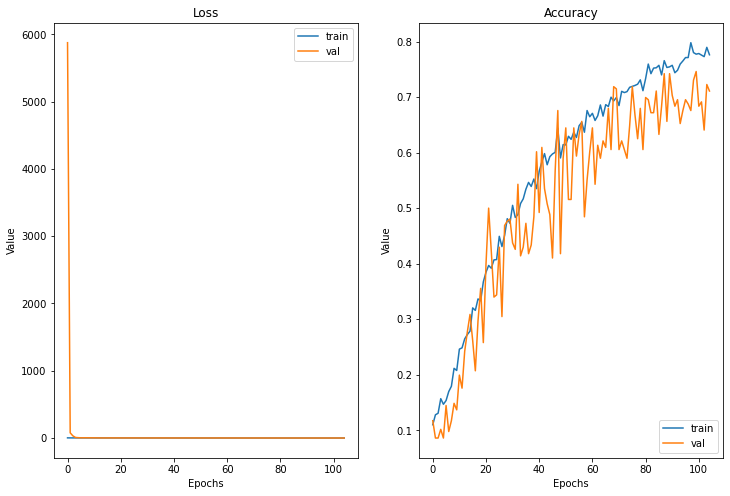

[[8.]
 [9.]
 [9.]
 [3.]
 [2.]
 [5.]
 [7.]
 [7.]
 [6.]
 [2.]
 [4.]
 [6.]
 [8.]
 [0.]
 [7.]
 [3.]
 [7.]
 [2.]
 [5.]
 [6.]
 [4.]
 [4.]
 [9.]
 [6.]
 [0.]
 [2.]
 [8.]
 [6.]
 [0.]
 [5.]
 [3.]
 [0.]
 [0.]
 [8.]
 [1.]
 [2.]
 [3.]
 [2.]
 [3.]
 [8.]
 [2.]
 [5.]
 [4.]
 [1.]
 [7.]
 [2.]
 [8.]
 [0.]
 [0.]
 [9.]
 [2.]
 [0.]
 [8.]
 [5.]
 [2.]
 [7.]
 [1.]
 [3.]
 [0.]
 [3.]
 [3.]
 [0.]
 [4.]
 [3.]
 [0.]
 [3.]
 [2.]
 [4.]
 [2.]
 [0.]
 [5.]
 [9.]
 [9.]
 [9.]
 [9.]
 [2.]
 [6.]
 [3.]
 [8.]
 [0.]
 [1.]
 [2.]
 [4.]
 [5.]
 [9.]
 [2.]
 [1.]
 [1.]
 [8.]
 [6.]
 [4.]
 [1.]
 [5.]
 [9.]
 [3.]
 [1.]
 [8.]
 [3.]
 [0.]
 [4.]
 [3.]
 [5.]
 [5.]
 [1.]
 [2.]
 [4.]
 [3.]
 [3.]
 [2.]
 [3.]
 [2.]
 [8.]
 [7.]
 [7.]
 [3.]
 [2.]
 [9.]
 [3.]
 [5.]
 [6.]
 [5.]
 [2.]
 [5.]
 [2.]
 [7.]
 [0.]
 [0.]
 [4.]
 [9.]
 [2.]
 [3.]
 [3.]
 [1.]
 [9.]
 [3.]
 [2.]
 [0.]
 [2.]
 [6.]
 [6.]
 [2.]
 [6.]
 [1.]
 [2.]
 [9.]
 [1.]
 [5.]
 [0.]
 [0.]
 [9.]
 [2.]
 [3.]
 [2.]
 [0.]
 [3.]
 [7.]
 [2.]
 [3.]
 [2.]
 [6.]
 [8.]
 [1.]
 [3.]
 [3.]
 [9.]
 [2.]
 [0.

56/56 [==============================] - ETA: 0s - loss: 1.7484 - accuracy: 0.3867
Epoch 00022: val_loss improved from 1.56261 to 1.35253, saving model to model1_best_0.h5
56/56 [==============================] - 2s 34ms/step - loss: 1.7484 - accuracy: 0.3867 - val_loss: 1.3525 - val_accuracy: 0.5234 - lr: 8.0000e-04
Epoch 23/300
54/56 [===========================>..] - ETA: 0s - loss: 1.6779 - accuracy: 0.4005
Epoch 00023: val_loss did not improve from 1.35253
56/56 [==============================] - 1s 24ms/step - loss: 1.6808 - accuracy: 0.3996 - val_loss: 1.6704 - val_accuracy: 0.4336 - lr: 8.0000e-04
Epoch 24/300
56/56 [==============================] - ETA: 0s - loss: 1.7446 - accuracy: 0.3951
Epoch 00024: val_loss did not improve from 1.35253
56/56 [==============================] - 1s 25ms/step - loss: 1.7446 - accuracy: 0.3951 - val_loss: 1.7555 - val_accuracy: 0.4570 - lr: 8.0000e-04
Epoch 25/300
54/56 [===========================>..] - ETA: 0s - loss: 1.6580 - accuracy: 0.42

Epoch 50/300
55/56 [============================>.] - ETA: 0s - loss: 1.0820 - accuracy: 0.6182
Epoch 00050: val_loss did not improve from 1.04430
56/56 [==============================] - 1s 22ms/step - loss: 1.0811 - accuracy: 0.6183 - val_loss: 1.2347 - val_accuracy: 0.6328 - lr: 3.2768e-04
Epoch 51/300
55/56 [============================>.] - ETA: 0s - loss: 1.0291 - accuracy: 0.6415
Epoch 00051: val_loss improved from 1.04430 to 0.91899, saving model to model1_best_0.h5
56/56 [==============================] - 2s 32ms/step - loss: 1.0232 - accuracy: 0.6451 - val_loss: 0.9190 - val_accuracy: 0.6992 - lr: 3.2768e-04
Epoch 52/300
55/56 [============================>.] - ETA: 0s - loss: 1.0568 - accuracy: 0.6438
Epoch 00052: val_loss did not improve from 0.91899
56/56 [==============================] - 1s 23ms/step - loss: 1.0561 - accuracy: 0.6423 - val_loss: 1.1519 - val_accuracy: 0.6250 - lr: 3.2768e-04
Epoch 53/300
55/56 [============================>.] - ETA: 0s - loss: 1.0824 - a

Epoch 78/300
55/56 [============================>.] - ETA: 0s - loss: 0.7892 - accuracy: 0.7369
Epoch 00078: val_loss did not improve from 0.80532
56/56 [==============================] - 1s 23ms/step - loss: 0.7868 - accuracy: 0.7360 - val_loss: 1.0079 - val_accuracy: 0.6914 - lr: 1.6777e-04
Epoch 79/300
55/56 [============================>.] - ETA: 0s - loss: 0.7768 - accuracy: 0.7324
Epoch 00079: val_loss did not improve from 0.80532
56/56 [==============================] - 1s 22ms/step - loss: 0.7808 - accuracy: 0.7310 - val_loss: 1.3588 - val_accuracy: 0.6094 - lr: 1.6777e-04
Epoch 80/300
55/56 [============================>.] - ETA: 0s - loss: 0.7779 - accuracy: 0.7301
Epoch 00080: val_loss did not improve from 0.80532
56/56 [==============================] - 1s 23ms/step - loss: 0.7791 - accuracy: 0.7305 - val_loss: 0.8425 - val_accuracy: 0.7344 - lr: 1.6777e-04
Epoch 81/300
55/56 [============================>.] - ETA: 0s - loss: 0.8081 - accuracy: 0.7205
Epoch 00081: val_loss 

Epoch 106/300
55/56 [============================>.] - ETA: 0s - loss: 0.6597 - accuracy: 0.7790 ETA: 0s - los
Epoch 00106: val_loss did not improve from 0.61787
56/56 [==============================] - 1s 23ms/step - loss: 0.6584 - accuracy: 0.7790 - val_loss: 0.7033 - val_accuracy: 0.7578 - lr: 6.8719e-05
Epoch 107/300
55/56 [============================>.] - ETA: 0s - loss: 0.6467 - accuracy: 0.7665
Epoch 00107: val_loss did not improve from 0.61787
56/56 [==============================] - 1s 22ms/step - loss: 0.6524 - accuracy: 0.7651 - val_loss: 0.6980 - val_accuracy: 0.7773 - lr: 5.4976e-05
Epoch 108/300
55/56 [============================>.] - ETA: 0s - loss: 0.6601 - accuracy: 0.7636
Epoch 00108: val_loss did not improve from 0.61787
56/56 [==============================] - 1s 23ms/step - loss: 0.6570 - accuracy: 0.7656 - val_loss: 0.7166 - val_accuracy: 0.7461 - lr: 5.4976e-05
Epoch 109/300
55/56 [============================>.] - ETA: 0s - loss: 0.6380 - accuracy: 0.7858
Epoc

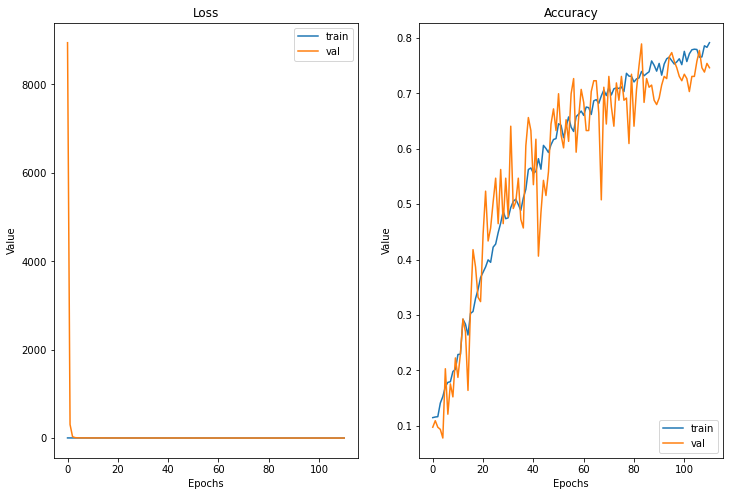

[[4.]
 [3.]
 [5.]
 [5.]
 [8.]
 [8.]
 [6.]
 [6.]
 [8.]
 [9.]
 [2.]
 [0.]
 [6.]
 [6.]
 [8.]
 [2.]
 [8.]
 [9.]
 [1.]
 [4.]
 [8.]
 [2.]
 [1.]
 [3.]
 [9.]
 [5.]
 [7.]
 [7.]
 [0.]
 [2.]
 [2.]
 [3.]
 [8.]
 [8.]
 [8.]
 [3.]
 [6.]
 [8.]
 [0.]
 [2.]
 [9.]
 [1.]
 [9.]
 [2.]
 [1.]
 [2.]
 [1.]
 [9.]
 [3.]
 [8.]
 [2.]
 [1.]
 [1.]
 [0.]
 [8.]
 [8.]
 [5.]
 [8.]
 [5.]
 [6.]
 [6.]
 [9.]
 [7.]
 [0.]
 [8.]
 [0.]
 [5.]
 [5.]
 [2.]
 [4.]
 [2.]
 [6.]
 [0.]
 [2.]
 [1.]
 [5.]
 [6.]
 [6.]
 [6.]
 [5.]
 [9.]
 [8.]
 [5.]
 [5.]
 [7.]
 [4.]
 [8.]
 [5.]
 [4.]
 [2.]
 [3.]
 [8.]
 [8.]
 [3.]
 [2.]
 [2.]
 [7.]
 [3.]
 [9.]
 [4.]
 [4.]
 [5.]
 [6.]
 [4.]
 [6.]
 [8.]
 [2.]
 [0.]
 [1.]
 [3.]
 [8.]
 [9.]
 [7.]
 [5.]
 [5.]
 [1.]
 [0.]
 [9.]
 [6.]
 [8.]
 [7.]
 [2.]
 [0.]
 [2.]
 [1.]
 [9.]
 [2.]
 [7.]
 [4.]
 [1.]
 [5.]
 [3.]
 [2.]
 [8.]
 [1.]
 [3.]
 [7.]
 [6.]
 [4.]
 [4.]
 [5.]
 [3.]
 [8.]
 [5.]
 [0.]
 [8.]
 [2.]
 [2.]
 [9.]
 [1.]
 [5.]
 [9.]
 [2.]
 [9.]
 [9.]
 [8.]
 [9.]
 [4.]
 [8.]
 [6.]
 [0.]
 [9.]
 [0.]
 [8.]
 [2.]
 [5.]
 [8.

55/56 [============================>.] - ETA: 0s - loss: 1.8264 - accuracy: 0.3818
Epoch 00022: val_loss did not improve from 1.93812
56/56 [==============================] - 1s 22ms/step - loss: 1.8261 - accuracy: 0.3828 - val_loss: 2.2460 - val_accuracy: 0.4023 - lr: 0.0010
Epoch 23/300
56/56 [==============================] - ETA: 0s - loss: 1.7195 - accuracy: 0.4040
Epoch 00023: val_loss improved from 1.93812 to 1.57771, saving model to model1_best_0.h5
56/56 [==============================] - 2s 33ms/step - loss: 1.7195 - accuracy: 0.4040 - val_loss: 1.5777 - val_accuracy: 0.4609 - lr: 0.0010
Epoch 24/300
55/56 [============================>.] - ETA: 0s - loss: 1.7328 - accuracy: 0.4102
Epoch 00024: val_loss did not improve from 1.57771
56/56 [==============================] - 1s 22ms/step - loss: 1.7259 - accuracy: 0.4113 - val_loss: 2.3925 - val_accuracy: 0.2969 - lr: 0.0010
Epoch 25/300
55/56 [============================>.] - ETA: 0s - loss: 1.6825 - accuracy: 0.4142
Epoch 000

Epoch 50/300
55/56 [============================>.] - ETA: 0s - loss: 1.0691 - accuracy: 0.6290
Epoch 00050: val_loss did not improve from 0.95827
56/56 [==============================] - 1s 22ms/step - loss: 1.0633 - accuracy: 0.6306 - val_loss: 1.0509 - val_accuracy: 0.6992 - lr: 5.1200e-04
Epoch 51/300
55/56 [============================>.] - ETA: 0s - loss: 1.0859 - accuracy: 0.6193
Epoch 00051: val_loss did not improve from 0.95827
56/56 [==============================] - 1s 22ms/step - loss: 1.0821 - accuracy: 0.6205 - val_loss: 1.1350 - val_accuracy: 0.6523 - lr: 5.1200e-04
Epoch 52/300
55/56 [============================>.] - ETA: 0s - loss: 1.0559 - accuracy: 0.6256
Epoch 00052: val_loss did not improve from 0.95827
56/56 [==============================] - 1s 22ms/step - loss: 1.0479 - accuracy: 0.6289 - val_loss: 1.0330 - val_accuracy: 0.7109 - lr: 5.1200e-04
Epoch 53/300
55/56 [============================>.] - ETA: 0s - loss: 1.0382 - accuracy: 0.6369
Epoch 00053: val_loss 

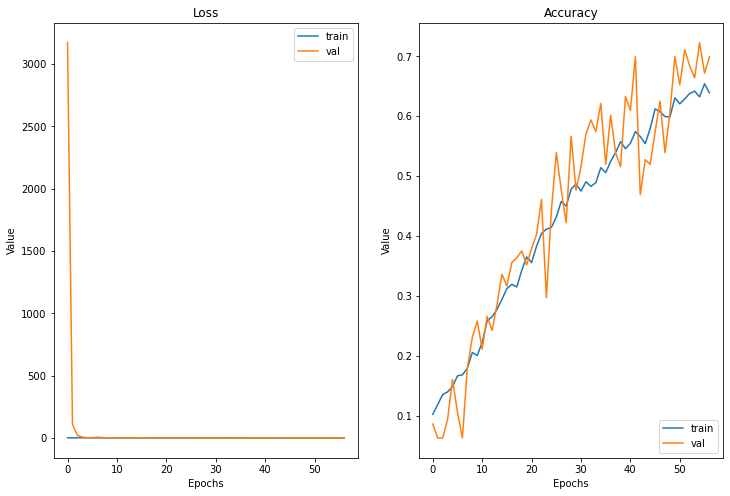

[[7.]
 [2.]
 [6.]
 [5.]
 [5.]
 [1.]
 [6.]
 [0.]
 [5.]
 [7.]
 [4.]
 [3.]
 [8.]
 [8.]
 [7.]
 [5.]
 [0.]
 [3.]
 [2.]
 [6.]
 [3.]
 [7.]
 [4.]
 [3.]
 [9.]
 [9.]
 [2.]
 [3.]
 [6.]
 [4.]
 [6.]
 [7.]
 [6.]
 [9.]
 [9.]
 [2.]
 [0.]
 [6.]
 [2.]
 [6.]
 [3.]
 [2.]
 [1.]
 [5.]
 [9.]
 [3.]
 [4.]
 [1.]
 [9.]
 [1.]
 [4.]
 [7.]
 [2.]
 [0.]
 [9.]
 [2.]
 [2.]
 [0.]
 [4.]
 [2.]
 [2.]
 [1.]
 [2.]
 [8.]
 [6.]
 [4.]
 [9.]
 [9.]
 [2.]
 [4.]
 [6.]
 [6.]
 [7.]
 [9.]
 [9.]
 [5.]
 [2.]
 [3.]
 [5.]
 [2.]
 [1.]
 [6.]
 [5.]
 [7.]
 [6.]
 [2.]
 [2.]
 [1.]
 [6.]
 [6.]
 [6.]
 [9.]
 [2.]
 [0.]
 [6.]
 [6.]
 [6.]
 [6.]
 [1.]
 [1.]
 [5.]
 [7.]
 [2.]
 [0.]
 [3.]
 [0.]
 [0.]
 [0.]
 [3.]
 [3.]
 [3.]
 [5.]
 [5.]
 [6.]
 [2.]
 [9.]
 [6.]
 [4.]
 [3.]
 [2.]
 [9.]
 [5.]
 [8.]
 [5.]
 [9.]
 [9.]
 [7.]
 [0.]
 [9.]
 [0.]
 [9.]
 [0.]
 [9.]
 [5.]
 [2.]
 [3.]
 [0.]
 [5.]
 [6.]
 [1.]
 [6.]
 [1.]
 [8.]
 [4.]
 [5.]
 [1.]
 [4.]
 [8.]
 [0.]
 [4.]
 [5.]
 [7.]
 [0.]
 [0.]
 [0.]
 [6.]
 [9.]
 [9.]
 [2.]
 [2.]
 [5.]
 [7.]
 [7.]
 [2.]
 [0.]
 [7.]
 [5.

Epoch 23/300
55/56 [============================>.] - ETA: 0s - loss: 1.7475 - accuracy: 0.3909
Epoch 00023: val_loss did not improve from 2.61275
56/56 [==============================] - 1s 23ms/step - loss: 1.7421 - accuracy: 0.3923 - val_loss: 3.1193 - val_accuracy: 0.2891 - lr: 8.0000e-04
Epoch 24/300
55/56 [============================>.] - ETA: 0s - loss: 1.7461 - accuracy: 0.3972
Epoch 00024: val_loss did not improve from 2.61275
56/56 [==============================] - 1s 23ms/step - loss: 1.7466 - accuracy: 0.3968 - val_loss: 3.7815 - val_accuracy: 0.2500 - lr: 8.0000e-04
Epoch 25/300
55/56 [============================>.] - ETA: 0s - loss: 1.7527 - accuracy: 0.3915
Epoch 00025: val_loss improved from 2.61275 to 2.22209, saving model to model1_best_0.h5
56/56 [==============================] - 2s 34ms/step - loss: 1.7501 - accuracy: 0.3917 - val_loss: 2.2221 - val_accuracy: 0.3828 - lr: 8.0000e-04
Epoch 26/300
56/56 [==============================] - ETA: 0s - loss: 1.6937 - a

54/56 [===========================>..] - ETA: 0s - loss: 1.0975 - accuracy: 0.6181
Epoch 00050: val_loss did not improve from 1.29673
56/56 [==============================] - 1s 25ms/step - loss: 1.1028 - accuracy: 0.6150 - val_loss: 1.3237 - val_accuracy: 0.6367 - lr: 5.1200e-04
Epoch 51/300
56/56 [==============================] - ETA: 0s - loss: 1.1493 - accuracy: 0.6155
Epoch 00051: val_loss improved from 1.29673 to 0.96992, saving model to model1_best_0.h5
56/56 [==============================] - 2s 34ms/step - loss: 1.1493 - accuracy: 0.6155 - val_loss: 0.9699 - val_accuracy: 0.6523 - lr: 5.1200e-04
Epoch 52/300
56/56 [==============================] - ETA: 0s - loss: 1.0524 - accuracy: 0.6406
Epoch 00052: val_loss did not improve from 0.96992
56/56 [==============================] - 1s 25ms/step - loss: 1.0524 - accuracy: 0.6406 - val_loss: 1.7552 - val_accuracy: 0.5742 - lr: 5.1200e-04
Epoch 53/300
55/56 [============================>.] - ETA: 0s - loss: 1.0979 - accuracy: 0.62

Epoch 78/300
56/56 [==============================] - ETA: 0s - loss: 0.7971 - accuracy: 0.7271
Epoch 00078: val_loss did not improve from 0.91044
56/56 [==============================] - 1s 23ms/step - loss: 0.7971 - accuracy: 0.7271 - val_loss: 1.0296 - val_accuracy: 0.6836 - lr: 2.6214e-04
Epoch 79/300
55/56 [============================>.] - ETA: 0s - loss: 0.7633 - accuracy: 0.7364
Epoch 00079: val_loss improved from 0.91044 to 0.83289, saving model to model1_best_0.h5
56/56 [==============================] - 2s 33ms/step - loss: 0.7583 - accuracy: 0.7383 - val_loss: 0.8329 - val_accuracy: 0.7266 - lr: 2.6214e-04
Epoch 80/300
55/56 [============================>.] - ETA: 0s - loss: 0.7206 - accuracy: 0.7494
Epoch 00080: val_loss improved from 0.83289 to 0.81293, saving model to model1_best_0.h5
56/56 [==============================] - 2s 33ms/step - loss: 0.7271 - accuracy: 0.7439 - val_loss: 0.8129 - val_accuracy: 0.7344 - lr: 2.6214e-04
Epoch 81/300
55/56 [======================

Epoch 106/300
55/56 [============================>.] - ETA: 0s - loss: 0.5803 - accuracy: 0.8074
Epoch 00106: val_loss did not improve from 0.73612
56/56 [==============================] - 1s 23ms/step - loss: 0.5825 - accuracy: 0.8075 - val_loss: 0.9796 - val_accuracy: 0.7227 - lr: 1.0737e-04
Epoch 107/300
54/56 [===========================>..] - ETA: 0s - loss: 0.5973 - accuracy: 0.7998
Epoch 00107: val_loss did not improve from 0.73612
56/56 [==============================] - 1s 24ms/step - loss: 0.5934 - accuracy: 0.8008 - val_loss: 0.9205 - val_accuracy: 0.7422 - lr: 1.0737e-04
Epoch 108/300
55/56 [============================>.] - ETA: 0s - loss: 0.5974 - accuracy: 0.8051
Epoch 00108: val_loss did not improve from 0.73612
56/56 [==============================] - 1s 24ms/step - loss: 0.5952 - accuracy: 0.8047 - val_loss: 0.9303 - val_accuracy: 0.7148 - lr: 1.0737e-04
Epoch 00108: early stopping


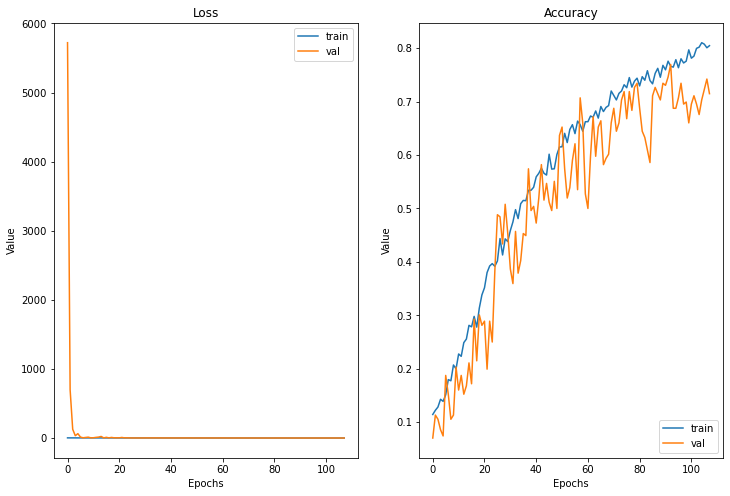

[[6.]
 [2.]
 [0.]
 [0.]
 [5.]
 [3.]
 [2.]
 [8.]
 [4.]
 [2.]
 [1.]
 [9.]
 [6.]
 [1.]
 [1.]
 [4.]
 [7.]
 [6.]
 [2.]
 [0.]
 [8.]
 [0.]
 [2.]
 [4.]
 [3.]
 [5.]
 [4.]
 [0.]
 [1.]
 [5.]
 [9.]
 [8.]
 [0.]
 [8.]
 [2.]
 [2.]
 [6.]
 [6.]
 [2.]
 [1.]
 [8.]
 [4.]
 [9.]
 [6.]
 [0.]
 [8.]
 [5.]
 [5.]
 [9.]
 [6.]
 [2.]
 [9.]
 [6.]
 [5.]
 [3.]
 [5.]
 [3.]
 [8.]
 [6.]
 [8.]
 [2.]
 [1.]
 [4.]
 [3.]
 [6.]
 [2.]
 [4.]
 [1.]
 [3.]
 [2.]
 [8.]
 [2.]
 [6.]
 [8.]
 [2.]
 [9.]
 [8.]
 [6.]
 [1.]
 [2.]
 [2.]
 [4.]
 [6.]
 [7.]
 [2.]
 [6.]
 [8.]
 [4.]
 [8.]
 [4.]
 [5.]
 [4.]
 [0.]
 [2.]
 [0.]
 [8.]
 [6.]
 [2.]
 [1.]
 [3.]
 [0.]
 [5.]
 [2.]
 [2.]
 [7.]
 [9.]
 [4.]
 [4.]
 [8.]
 [4.]
 [4.]
 [4.]
 [4.]
 [9.]
 [8.]
 [2.]
 [3.]
 [5.]
 [2.]
 [5.]
 [6.]
 [1.]
 [4.]
 [3.]
 [6.]
 [4.]
 [2.]
 [8.]
 [4.]
 [2.]
 [0.]
 [4.]
 [1.]
 [2.]
 [2.]
 [4.]
 [6.]
 [5.]
 [5.]
 [6.]
 [3.]
 [6.]
 [4.]
 [7.]
 [2.]
 [0.]
 [5.]
 [0.]
 [8.]
 [5.]
 [2.]
 [9.]
 [5.]
 [3.]
 [9.]
 [2.]
 [0.]
 [7.]
 [9.]
 [0.]
 [7.]
 [2.]
 [3.]
 [5.]
 [8.]
 [8.]
 [2.

55/56 [============================>.] - ETA: 0s - loss: 1.8740 - accuracy: 0.3318
Epoch 00022: val_loss did not improve from 1.96437
56/56 [==============================] - 1s 23ms/step - loss: 1.8762 - accuracy: 0.3304 - val_loss: 4.9537 - val_accuracy: 0.3398 - lr: 8.0000e-04
Epoch 23/300
55/56 [============================>.] - ETA: 0s - loss: 1.8835 - accuracy: 0.3614
Epoch 00023: val_loss did not improve from 1.96437
56/56 [==============================] - 1s 23ms/step - loss: 1.8744 - accuracy: 0.3650 - val_loss: 116.9089 - val_accuracy: 0.1133 - lr: 8.0000e-04
Epoch 24/300
55/56 [============================>.] - ETA: 0s - loss: 1.8070 - accuracy: 0.3898
Epoch 00024: val_loss did not improve from 1.96437
56/56 [==============================] - 1s 23ms/step - loss: 1.8102 - accuracy: 0.3873 - val_loss: 148.9413 - val_accuracy: 0.1602 - lr: 8.0000e-04
Epoch 25/300
55/56 [============================>.] - ETA: 0s - loss: 1.7994 - accuracy: 0.3761
Epoch 00025: val_loss did not i

Epoch 50/300
54/56 [===========================>..] - ETA: 0s - loss: 1.1570 - accuracy: 0.6175
Epoch 00050: val_loss did not improve from 1.42539
56/56 [==============================] - 1s 23ms/step - loss: 1.1502 - accuracy: 0.6194 - val_loss: 3.3858 - val_accuracy: 0.4648 - lr: 3.2768e-04
Epoch 51/300
55/56 [============================>.] - ETA: 0s - loss: 1.2336 - accuracy: 0.5750
Epoch 00051: val_loss did not improve from 1.42539
56/56 [==============================] - 1s 23ms/step - loss: 1.2380 - accuracy: 0.5742 - val_loss: 1.8908 - val_accuracy: 0.5234 - lr: 3.2768e-04
Epoch 52/300
55/56 [============================>.] - ETA: 0s - loss: 1.1685 - accuracy: 0.5920
Epoch 00052: val_loss did not improve from 1.42539
56/56 [==============================] - 1s 23ms/step - loss: 1.1699 - accuracy: 0.5904 - val_loss: 1.9944 - val_accuracy: 0.6367 - lr: 3.2768e-04
Epoch 53/300
55/56 [============================>.] - ETA: 0s - loss: 1.1688 - accuracy: 0.5858
Epoch 00053: val_loss 

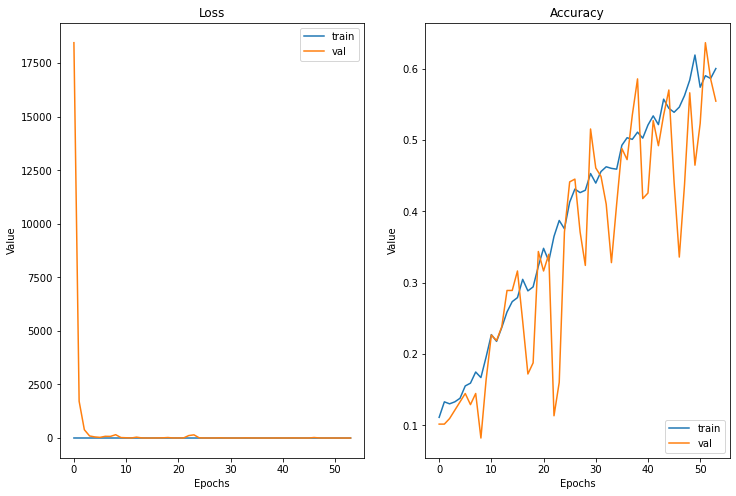

[[6.]
 [2.]
 [2.]
 [5.]
 [0.]
 [3.]
 [3.]
 [4.]
 [9.]
 [2.]
 [5.]
 [2.]
 [6.]
 [4.]
 [6.]
 [1.]
 [6.]
 [7.]
 [2.]
 [3.]
 [8.]
 [1.]
 [1.]
 [5.]
 [1.]
 [1.]
 [6.]
 [4.]
 [7.]
 [1.]
 [8.]
 [5.]
 [7.]
 [3.]
 [6.]
 [7.]
 [9.]
 [6.]
 [2.]
 [8.]
 [7.]
 [4.]
 [8.]
 [5.]
 [7.]
 [6.]
 [8.]
 [9.]
 [2.]
 [7.]
 [0.]
 [4.]
 [2.]
 [2.]
 [8.]
 [2.]
 [2.]
 [6.]
 [3.]
 [8.]
 [1.]
 [3.]
 [2.]
 [2.]
 [2.]
 [2.]
 [6.]
 [6.]
 [2.]
 [5.]
 [2.]
 [8.]
 [1.]
 [8.]
 [7.]
 [3.]
 [2.]
 [6.]
 [3.]
 [4.]
 [2.]
 [6.]
 [6.]
 [2.]
 [9.]
 [1.]
 [6.]
 [8.]
 [4.]
 [3.]
 [8.]
 [3.]
 [7.]
 [4.]
 [2.]
 [2.]
 [2.]
 [1.]
 [7.]
 [1.]
 [6.]
 [1.]
 [3.]
 [4.]
 [9.]
 [3.]
 [2.]
 [2.]
 [9.]
 [6.]
 [2.]
 [3.]
 [6.]
 [8.]
 [6.]
 [9.]
 [9.]
 [7.]
 [9.]
 [8.]
 [6.]
 [8.]
 [9.]
 [2.]
 [3.]
 [2.]
 [6.]
 [8.]
 [3.]
 [0.]
 [1.]
 [2.]
 [3.]
 [2.]
 [3.]
 [8.]
 [1.]
 [5.]
 [2.]
 [2.]
 [3.]
 [4.]
 [1.]
 [2.]
 [9.]
 [1.]
 [2.]
 [3.]
 [6.]
 [5.]
 [1.]
 [8.]
 [3.]
 [4.]
 [9.]
 [6.]
 [4.]
 [4.]
 [3.]
 [5.]
 [2.]
 [8.]
 [7.]
 [2.]
 [7.]
 [3.]
 [0.

55/56 [============================>.] - ETA: 0s - loss: 1.8784 - accuracy: 0.3511
Epoch 00022: val_loss did not improve from 1.70860
56/56 [==============================] - 1s 23ms/step - loss: 1.8832 - accuracy: 0.3510 - val_loss: 2.4084 - val_accuracy: 0.2344 - lr: 0.0010
Epoch 23/300
55/56 [============================>.] - ETA: 0s - loss: 1.7430 - accuracy: 0.3898
Epoch 00023: val_loss improved from 1.70860 to 1.59772, saving model to model1_best_0.h5
56/56 [==============================] - 2s 33ms/step - loss: 1.7468 - accuracy: 0.3878 - val_loss: 1.5977 - val_accuracy: 0.4688 - lr: 0.0010
Epoch 24/300
55/56 [============================>.] - ETA: 0s - loss: 1.7610 - accuracy: 0.3761
Epoch 00024: val_loss did not improve from 1.59772
56/56 [==============================] - 1s 23ms/step - loss: 1.7526 - accuracy: 0.3783 - val_loss: 2.2382 - val_accuracy: 0.3398 - lr: 0.0010
Epoch 25/300
55/56 [============================>.] - ETA: 0s - loss: 1.7682 - accuracy: 0.3824
Epoch 000

Epoch 50/300
55/56 [============================>.] - ETA: 0s - loss: 1.1950 - accuracy: 0.6085
Epoch 00050: val_loss did not improve from 1.03045
56/56 [==============================] - 1s 23ms/step - loss: 1.1960 - accuracy: 0.6083 - val_loss: 1.6043 - val_accuracy: 0.5156 - lr: 6.4000e-04
Epoch 51/300
55/56 [============================>.] - ETA: 0s - loss: 1.1436 - accuracy: 0.6051
Epoch 00051: val_loss did not improve from 1.03045
56/56 [==============================] - 1s 23ms/step - loss: 1.1450 - accuracy: 0.6049 - val_loss: 1.8219 - val_accuracy: 0.4883 - lr: 6.4000e-04
Epoch 52/300
55/56 [============================>.] - ETA: 0s - loss: 1.1203 - accuracy: 0.6074
Epoch 00052: val_loss did not improve from 1.03045
56/56 [==============================] - 1s 23ms/step - loss: 1.1257 - accuracy: 0.6077 - val_loss: 1.1679 - val_accuracy: 0.6484 - lr: 5.1200e-04
Epoch 53/300
55/56 [============================>.] - ETA: 0s - loss: 1.0897 - accuracy: 0.6205
Epoch 00053: val_loss 

Epoch 78/300
55/56 [============================>.] - ETA: 0s - loss: 0.7869 - accuracy: 0.7244
Epoch 00078: val_loss did not improve from 0.70654
56/56 [==============================] - 1s 23ms/step - loss: 0.7825 - accuracy: 0.7260 - val_loss: 0.7271 - val_accuracy: 0.7656 - lr: 2.0972e-04
Epoch 79/300
56/56 [==============================] - ETA: 0s - loss: 0.8024 - accuracy: 0.7310
Epoch 00079: val_loss did not improve from 0.70654
56/56 [==============================] - 1s 23ms/step - loss: 0.8024 - accuracy: 0.7310 - val_loss: 1.0479 - val_accuracy: 0.6484 - lr: 2.0972e-04
Epoch 00079: early stopping


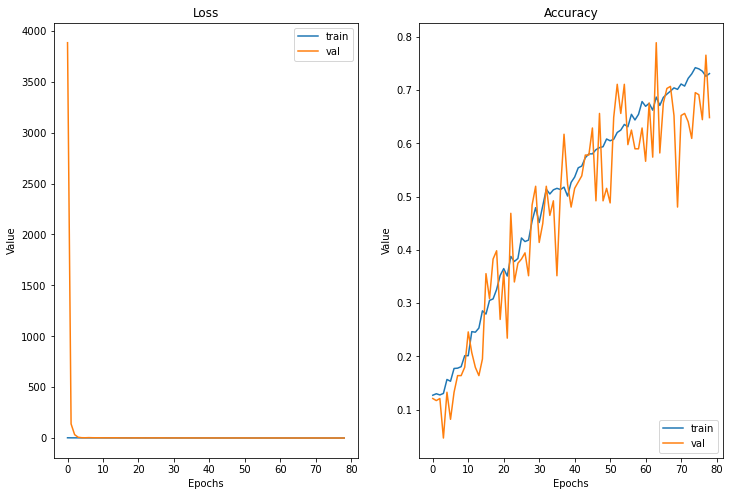

[[0.]
 [8.]
 [0.]
 [9.]
 [7.]
 [7.]
 [7.]
 [0.]
 [3.]
 [1.]
 [8.]
 [7.]
 [5.]
 [2.]
 [3.]
 [0.]
 [0.]
 [3.]
 [1.]
 [1.]
 [0.]
 [3.]
 [9.]
 [7.]
 [5.]
 [7.]
 [3.]
 [8.]
 [1.]
 [6.]
 [7.]
 [6.]
 [3.]
 [7.]
 [4.]
 [1.]
 [0.]
 [7.]
 [5.]
 [2.]
 [1.]
 [4.]
 [2.]
 [5.]
 [7.]
 [9.]
 [2.]
 [3.]
 [1.]
 [5.]
 [8.]
 [1.]
 [1.]
 [8.]
 [2.]
 [0.]
 [3.]
 [7.]
 [9.]
 [3.]
 [4.]
 [9.]
 [8.]
 [1.]
 [3.]
 [7.]
 [9.]
 [7.]
 [2.]
 [9.]
 [1.]
 [1.]
 [3.]
 [7.]
 [3.]
 [3.]
 [0.]
 [2.]
 [8.]
 [7.]
 [4.]
 [3.]
 [7.]
 [0.]
 [1.]
 [0.]
 [4.]
 [1.]
 [8.]
 [3.]
 [9.]
 [8.]
 [8.]
 [1.]
 [7.]
 [7.]
 [5.]
 [2.]
 [1.]
 [3.]
 [4.]
 [6.]
 [6.]
 [9.]
 [2.]
 [3.]
 [6.]
 [9.]
 [7.]
 [8.]
 [0.]
 [2.]
 [6.]
 [0.]
 [7.]
 [4.]
 [5.]
 [3.]
 [0.]
 [8.]
 [8.]
 [8.]
 [6.]
 [8.]
 [8.]
 [8.]
 [3.]
 [9.]
 [4.]
 [8.]
 [9.]
 [9.]
 [8.]
 [9.]
 [1.]
 [3.]
 [1.]
 [5.]
 [1.]
 [7.]
 [3.]
 [2.]
 [8.]
 [6.]
 [6.]
 [0.]
 [1.]
 [9.]
 [2.]
 [6.]
 [3.]
 [6.]
 [1.]
 [5.]
 [0.]
 [7.]
 [8.]
 [3.]
 [1.]
 [7.]
 [5.]
 [9.]
 [2.]
 [9.]
 [9.]
 [3.]
 [7.

55/56 [============================>.] - ETA: 0s - loss: 1.9321 - accuracy: 0.3500
Epoch 00022: val_loss did not improve from 2.23691
56/56 [==============================] - 1s 23ms/step - loss: 1.9242 - accuracy: 0.3544 - val_loss: 5.6147 - val_accuracy: 0.3594 - lr: 8.0000e-04
Epoch 23/300
55/56 [============================>.] - ETA: 0s - loss: 1.8785 - accuracy: 0.3483
Epoch 00023: val_loss did not improve from 2.23691
56/56 [==============================] - 1s 23ms/step - loss: 1.8785 - accuracy: 0.3477 - val_loss: 45.0217 - val_accuracy: 0.2070 - lr: 8.0000e-04
Epoch 24/300
55/56 [============================>.] - ETA: 0s - loss: 1.8006 - accuracy: 0.3517
Epoch 00024: val_loss did not improve from 2.23691
56/56 [==============================] - 1s 22ms/step - loss: 1.7920 - accuracy: 0.3566 - val_loss: 3.0618 - val_accuracy: 0.3867 - lr: 6.4000e-04
Epoch 25/300
56/56 [==============================] - ETA: 0s - loss: 1.8153 - accuracy: 0.3789
Epoch 00025: val_loss improved fro

54/56 [===========================>..] - ETA: 0s - loss: 1.2774 - accuracy: 0.5440
Epoch 00049: val_loss did not improve from 1.01632
56/56 [==============================] - 1s 23ms/step - loss: 1.2705 - accuracy: 0.5474 - val_loss: 1.5082 - val_accuracy: 0.5234 - lr: 4.0960e-04
Epoch 50/300
55/56 [============================>.] - ETA: 0s - loss: 1.2557 - accuracy: 0.5636
Epoch 00050: val_loss did not improve from 1.01632
56/56 [==============================] - 1s 23ms/step - loss: 1.2595 - accuracy: 0.5631 - val_loss: 1.4682 - val_accuracy: 0.5391 - lr: 3.2768e-04
Epoch 51/300
55/56 [============================>.] - ETA: 0s - loss: 1.2144 - accuracy: 0.5813
Epoch 00051: val_loss improved from 1.01632 to 0.88671, saving model to model1_best_0.h5
56/56 [==============================] - 2s 32ms/step - loss: 1.2230 - accuracy: 0.5787 - val_loss: 0.8867 - val_accuracy: 0.6836 - lr: 3.2768e-04
Epoch 52/300
55/56 [============================>.] - ETA: 0s - loss: 1.2077 - accuracy: 0.57

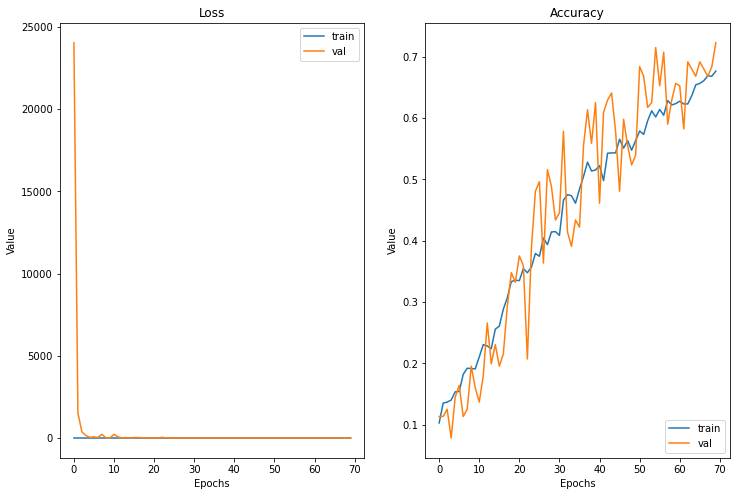

[[4.]
 [0.]
 [5.]
 [6.]
 [5.]
 [1.]
 [0.]
 [3.]
 [2.]
 [3.]
 [0.]
 [3.]
 [6.]
 [8.]
 [1.]
 [9.]
 [2.]
 [9.]
 [5.]
 [9.]
 [2.]
 [6.]
 [1.]
 [2.]
 [1.]
 [7.]
 [5.]
 [0.]
 [5.]
 [4.]
 [1.]
 [2.]
 [2.]
 [6.]
 [8.]
 [2.]
 [7.]
 [2.]
 [2.]
 [8.]
 [7.]
 [5.]
 [3.]
 [5.]
 [9.]
 [5.]
 [2.]
 [5.]
 [2.]
 [6.]
 [0.]
 [0.]
 [0.]
 [0.]
 [6.]
 [1.]
 [2.]
 [5.]
 [3.]
 [0.]
 [1.]
 [2.]
 [2.]
 [5.]
 [8.]
 [1.]
 [0.]
 [7.]
 [0.]
 [1.]
 [8.]
 [7.]
 [0.]
 [9.]
 [4.]
 [2.]
 [0.]
 [6.]
 [5.]
 [5.]
 [2.]
 [3.]
 [1.]
 [0.]
 [2.]
 [4.]
 [4.]
 [8.]
 [9.]
 [2.]
 [0.]
 [4.]
 [9.]
 [2.]
 [6.]
 [8.]
 [0.]
 [8.]
 [5.]
 [4.]
 [7.]
 [6.]
 [2.]
 [5.]
 [9.]
 [2.]
 [2.]
 [4.]
 [0.]
 [6.]
 [4.]
 [0.]
 [6.]
 [0.]
 [7.]
 [0.]
 [8.]
 [7.]
 [1.]
 [4.]
 [9.]
 [7.]
 [4.]
 [3.]
 [0.]
 [0.]
 [2.]
 [1.]
 [8.]
 [8.]
 [0.]
 [0.]
 [0.]
 [4.]
 [2.]
 [5.]
 [0.]
 [8.]
 [1.]
 [2.]
 [6.]
 [9.]
 [4.]
 [2.]
 [2.]
 [2.]
 [6.]
 [0.]
 [9.]
 [3.]
 [2.]
 [1.]
 [4.]
 [0.]
 [9.]
 [2.]
 [1.]
 [1.]
 [0.]
 [3.]
 [4.]
 [8.]
 [1.]
 [2.]
 [2.]
 [7.]
 [0.

55/56 [============================>.] - ETA: 0s - loss: 1.7966 - accuracy: 0.3773
Epoch 00022: val_loss did not improve from 1.73178
56/56 [==============================] - 1s 23ms/step - loss: 1.7926 - accuracy: 0.3783 - val_loss: 2.3066 - val_accuracy: 0.3125 - lr: 0.0010
Epoch 23/300
55/56 [============================>.] - ETA: 0s - loss: 1.7876 - accuracy: 0.3864
Epoch 00023: val_loss improved from 1.73178 to 1.50552, saving model to model1_best_0.h5
56/56 [==============================] - 2s 33ms/step - loss: 1.7780 - accuracy: 0.3901 - val_loss: 1.5055 - val_accuracy: 0.4570 - lr: 0.0010
Epoch 24/300
54/56 [===========================>..] - ETA: 0s - loss: 1.6955 - accuracy: 0.4080
Epoch 00024: val_loss did not improve from 1.50552
56/56 [==============================] - 1s 23ms/step - loss: 1.6973 - accuracy: 0.4079 - val_loss: 2.4148 - val_accuracy: 0.3242 - lr: 0.0010
Epoch 25/300
55/56 [============================>.] - ETA: 0s - loss: 1.6593 - accuracy: 0.4227
Epoch 000

Epoch 50/300
55/56 [============================>.] - ETA: 0s - loss: 1.0463 - accuracy: 0.6455
Epoch 00050: val_loss did not improve from 1.25120
56/56 [==============================] - 1s 24ms/step - loss: 1.0506 - accuracy: 0.6440 - val_loss: 1.4924 - val_accuracy: 0.6172 - lr: 4.0960e-04
Epoch 51/300
54/56 [===========================>..] - ETA: 0s - loss: 1.0576 - accuracy: 0.6429
Epoch 00051: val_loss did not improve from 1.25120
56/56 [==============================] - 1s 25ms/step - loss: 1.0567 - accuracy: 0.6429 - val_loss: 1.3443 - val_accuracy: 0.6133 - lr: 4.0960e-04
Epoch 52/300
56/56 [==============================] - ETA: 0s - loss: 1.0947 - accuracy: 0.6367
Epoch 00052: val_loss did not improve from 1.25120
56/56 [==============================] - 1s 25ms/step - loss: 1.0947 - accuracy: 0.6367 - val_loss: 1.5751 - val_accuracy: 0.5547 - lr: 4.0960e-04
Epoch 53/300
56/56 [==============================] - ETA: 0s - loss: 1.0623 - accuracy: 0.6401
Epoch 00053: val_loss 

Epoch 00077: early stopping


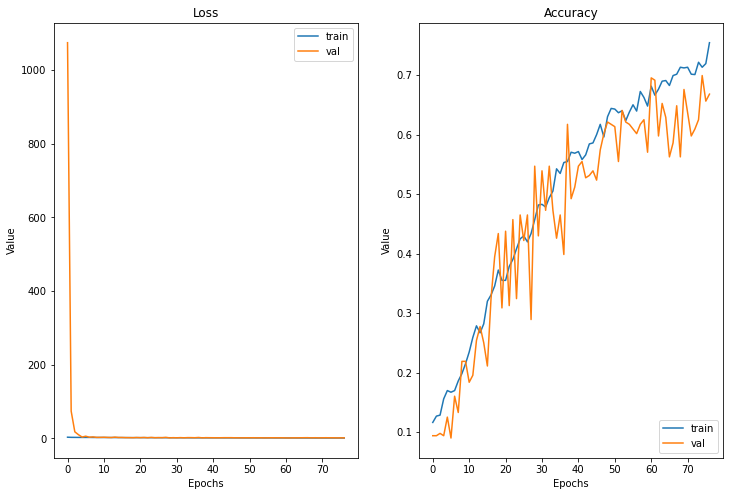

[[5.]
 [3.]
 [4.]
 [6.]
 [8.]
 [4.]
 [5.]
 [2.]
 [6.]
 [6.]
 [8.]
 [4.]
 [5.]
 [1.]
 [4.]
 [6.]
 [6.]
 [2.]
 [9.]
 [6.]
 [0.]
 [1.]
 [2.]
 [0.]
 [2.]
 [8.]
 [6.]
 [3.]
 [8.]
 [7.]
 [8.]
 [5.]
 [2.]
 [1.]
 [4.]
 [2.]
 [2.]
 [2.]
 [8.]
 [7.]
 [8.]
 [8.]
 [2.]
 [4.]
 [8.]
 [0.]
 [0.]
 [8.]
 [6.]
 [6.]
 [1.]
 [6.]
 [6.]
 [8.]
 [3.]
 [5.]
 [3.]
 [4.]
 [8.]
 [8.]
 [6.]
 [7.]
 [3.]
 [6.]
 [2.]
 [6.]
 [7.]
 [2.]
 [4.]
 [2.]
 [8.]
 [3.]
 [1.]
 [0.]
 [5.]
 [2.]
 [5.]
 [6.]
 [8.]
 [3.]
 [7.]
 [6.]
 [3.]
 [6.]
 [8.]
 [7.]
 [8.]
 [6.]
 [1.]
 [4.]
 [4.]
 [4.]
 [8.]
 [2.]
 [9.]
 [4.]
 [0.]
 [6.]
 [6.]
 [0.]
 [4.]
 [5.]
 [7.]
 [5.]
 [6.]
 [5.]
 [2.]
 [5.]
 [7.]
 [4.]
 [4.]
 [9.]
 [0.]
 [6.]
 [1.]
 [0.]
 [4.]
 [1.]
 [5.]
 [2.]
 [0.]
 [6.]
 [5.]
 [6.]
 [7.]
 [6.]
 [6.]
 [5.]
 [3.]
 [2.]
 [4.]
 [8.]
 [4.]
 [8.]
 [3.]
 [1.]
 [8.]
 [7.]
 [3.]
 [1.]
 [3.]
 [3.]
 [7.]
 [8.]
 [3.]
 [1.]
 [3.]
 [3.]
 [8.]
 [6.]
 [2.]
 [9.]
 [7.]
 [8.]
 [9.]
 [6.]
 [2.]
 [3.]
 [7.]
 [8.]
 [6.]
 [2.]
 [2.]
 [8.]
 [9.]
 [4.]
 [9.

In [20]:
RR_train, RR_test = get_stacking(DenseNet, X_trains, y_trains)

In [22]:
RR_train

array([[5],
       [0],
       [4],
       ...,
       [8],
       [0],
       [5]])

In [21]:
RR_test

array([[6],
       [9],
       [8],
       ...,
       [6],
       [3],
       [0]])

## Pickle 파일 저장

In [23]:
pickle.dump(RR_train, open("./pickle/RR_train.pkl", "wb"))
pickle.dump(RR_test, open("./pickle/RR_test.pkl", "wb"))